In [1]:
import numpy as np
import lumicks.pylake as lk
import matplotlib.pyplot as plt
import h5py
from sklearn.linear_model import LinearRegression

In [15]:
d = h5py.File('/home/kris/proj/.data/tweez/yhsp2.h5', 'r')
signal = d['Trap position']['1X']
first = np.argwhere(np.asarray(signal) < 2)[0][0]
top = np.max(signal[first:])
first = np.argwhere(np.asarray(signal) <= top)[0][0]
signal = signal[first:]
distance = d['Distance']['Piezo Distance'][first:]
distance = distance - np.amin(distance)
force = d['Force HF']['Force 1x'][first:]

toseconds = 1e-9
duration = (d['Force LF']['Force 1x'][:][-1][0] \
            - d['Force LF']['Force 1x'][:][0][0]) * toseconds
frequency = len(force) / duration
print(duration, frequency)

681.2630016 73355.54827229884


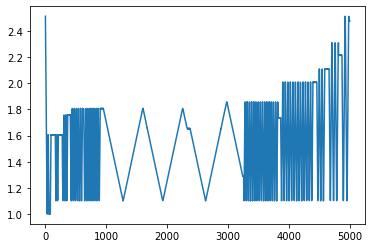

In [3]:
plt.plot(signal[::10000])
#plt.xlim((4000,4400))

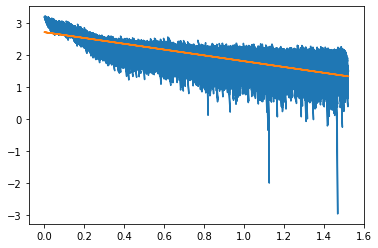

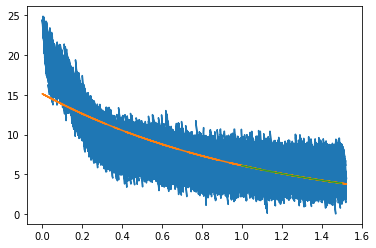

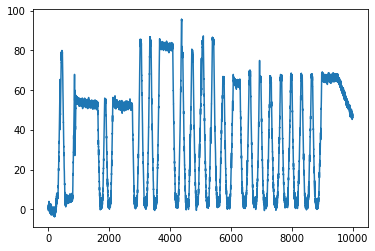

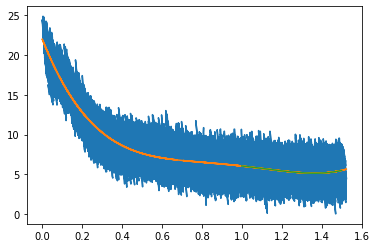

In [4]:
from sklearn.linear_model import LinearRegression
x = distance[:300000]
y = np.nan_to_num(np.log(force[:300000]))
plt.plot(x,y)
m,b = np.polyfit(x,y,1)
plt.plot(x,m * x + b)
plt.figure()
plt.plot(x,force[:300000])
plt.plot(x,np.exp(m * x + b))
xtra = np.linspace(1,1.5,100)
plt.plot(xtra,np.exp(m * xtra + b))

plt.figure()
newforce = force - np.exp(m * distance + b)
plt.plot(newforce[:10000000:1000])
poly = np.polyfit(x,force[:300000], 4)
P = np.poly1d(poly)
plt.figure()
plt.plot(x,force[:300000])
plt.plot(x, P(x))
plt.plot(xtra,P(xtra))
newnewforce = force - P(distance)

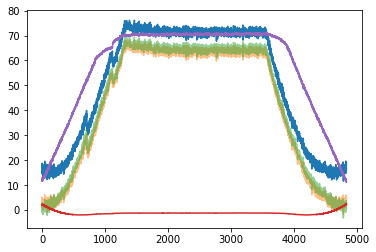

In [7]:
pn = 5
region = slice(pulls[pn][0], pulls[pn][1], 100)
plt.plot(force[region])
plt.plot(newforce[region], alpha=0.5)
plt.plot(newnewforce[region], alpha=0.5)
plt.plot(newforce[region] - newnewforce[region])


plt.plot(distance[pulls[pn][0]:pulls[pn][1]:100] * 100)

In [19]:
%matplotlib inline
#from util import find_pulls
pulls = find_pulls(signal)
print(len(pulls))
print(max(signal))

53
2.512947189994156


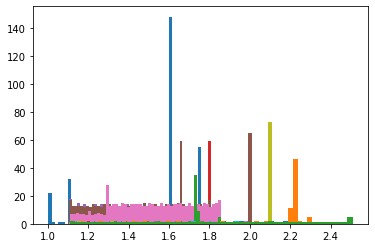

In [20]:
dict_pulls = []
for index, pull in enumerate(pulls):
    region = signal[pull[0]:pull[1]][::10000]
    bars = plt.hist(region, bins=50)
    first_top = last_top = 0
    time = 0
    if index:
        time = int((pull[0] - pulls[index - 1][1]) / frequency * 1000)
    for index, sig in enumerate(region):
        if not first_top and sig > bars[1][-2]:
            first_top = pull[0] + index * 10000
        if first_top and not last_top and sig < bars[1][-2]:
            last_top = pull[0] + index * 10000
    dict_pulls.append({'start': pull[0],
                      'stop': pull[1],
                       'len': pull[1] - pull[0],
                      'pull_stop': first_top,
                      'relax_start': last_top,
                      'rest': time})

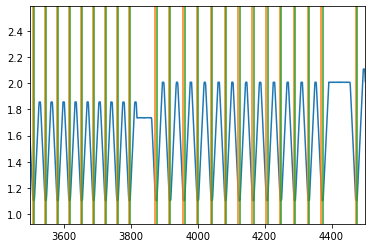

In [21]:
plt.plot(signal[::10000])
for (start, stop) in pulls:
    plt.axvline(start // 10000, c='tab:green')
    plt.axvline(stop // 10000, c='tab:orange')
    plt.xlim((3500,4500))

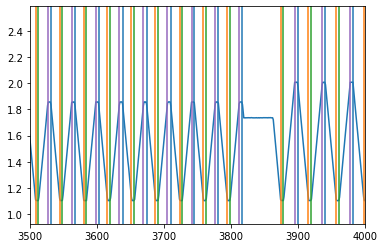

In [22]:
plt.plot(signal[::10000])
for pull in dict_pulls:
    plt.axvline(pull['start'] // 10000, c='tab:green')
    plt.axvline(pull['stop'] // 10000, c='tab:orange')
    plt.axvline(pull['pull_stop'] // 10000, c='tab:purple')
    plt.axvline(pull['relax_start'] // 10000, c='tab:blue')
    
    plt.xlim((3500,4000))

In [11]:
from scipy.stats import hmean
target = 5000
pullens = [pull[1] - pull[0] for pull in pulls]
pull_points = int(hmean(pullens))
# pull_points = pulls[0][1] - pulls[0][0]
kernel_size = pull_points // 5000
kernel = np.ones(kernel_size) / kernel_size
smooth_force = np.convolve(force, kernel, mode='same')

In [12]:
print(pulls[0])
#print(len(curves), len(pulls))

(337000, 4546000)


In [13]:
curves = {}
for index, pull in enumerate(dict_pulls):
    identifier = 'curve_' + str(index + 1)
    if pull['len'] > 2 * target * kernel_size or pull['len'] < target * kernel_size / 2:
        continue
    curves[identifier] = {'pull_force': smooth_force[pull['start']:pull['pull_stop']][::kernel_size],
                         'dist': distance[pull[0]:pull[1]][::kernel_size],
                         'sign': signal[pull[0]:pull[1]][::kernel_size],
                         'rest': pull['rest']}
print(curves.keys())

KeyError: 0

In [ ]:
from util import write_csv

write_csv('/home/kris/proj/.data/tweez/yhsp2.csv', curves)

In [ ]:
for index, curve in enumerate(curves.values()):
    if index < 0:
        continue
    elif index > 5:
        break
    fix,ax1=plt.subplots()
    ax1.plot(curve['force'], c='tab:blue', alpha=0.8)
    ax2 = ax1.twinx()
    ax2.plot(curve['dist'], c='tab:orange', alpha=0.8)
    ax3 = ax1.twinx()
    ax3.plot(curve['sign'], c='tab:green')

In [ ]:
plt.plot(smooth_force)

In [ ]:
print(bars[0], bars[1])

In [ ]:
import h5py
for curve in curves

In [ ]:
import csv
with open('/home/kris/proj/.data/tweez/split_curves.csv', 'w') as f:
    wr = csv.writer(f)
    for curve_id, curve in curves.items():
        wr.writerow([curve_id, *[dist for dist in curve['dist']]])
        wr.writerow([curve_id, *[force for force in curve['force']]])

In [ ]:
for curve in curves.values():
    plt.figure()
    bins = plt.hist(curve['force'], bins=50)
    plt.axhline(np.mean(bins[0]), c='tab:orange')
    plt.axhline(np.mean(bins[0]) + np.std(bins[0]), c='tab:orange', alpha=0.5)
    print(np.mean(bins[0]), np.std(bins[0]))
    #plt.figure()
    #plt.plot(np.diff(curve['force']))

In [ ]:
plt.plot(curves['curve_60_573ms']['force'])
print(min(curves['curve_60_573ms']['force']))


In [ ]:
def simple_slope(f, index, size):
    return (f[min(len(f) - 1, index + size)] - f[max(0, index - size)]) / (2 * size)

In [ ]:
for curve in curves.values():
    slopes = []
    for index, force in enumerate(curve['force']):
        slopes.append(simple_slope(curve['force'], index, 50))
    plt.plot(slopes)
    #plt.plot(curve['force'])
plt.axhline(0)

In [ ]:
single = curves['curve_1_0ms']
slopes = []
for index, force in enumerate(single['force']):
    slopes.append(simple_slope(single['force'], index, 50))
plt.plot(slopes)

subzeros = []
for index, slope in enumerate(slopes[1000:-1000]):
    if slope < 0:
        subzeros.append(index)
for index, sub in enumerate(reversed(subzeros)):
    if subzeros[-1] == subzeros[-2] + 1:
        subzeros.pop(-1)
    else:
        break
    #print(sub, index)
print(len(subzeros))
plt.axvline(subzeros[0] + 1000)
plt.axvline(subzeros[-1] + 1000)
plt.figure()
plt.plot(single['force'])
plt.axvline(subzeros[0] + 1000)
plt.axvline(subzeros[-1] + 1000)


In [18]:
def find_pulls(signal, bins=100, stepsize=1000, verbose=False):
    hist, edges = np.histogram(signal[::stepsize], bins=bins)
    highest = np.argmax(hist)
    second = np.argmax([heigth for index, heigth in enumerate(hist)
                        if index != highest])

    low_signal = edges[min(highest, second) + 1]
    high_signal = edges[max(highest, second)]

    pulling = True
    relaxing = True
    pulls = []
    for index, position in enumerate(signal[::stepsize]):
        if not index % 100 and verbose:
            print(index * stepsize)
        if pulling and relaxing:  # ignore first partial pull
            if position < low_signal:
                pulling = False
                relaxing = False
        elif not pulling and not relaxing and position >= low_signal:
            pulling = True
            start = max(index * stepsize - stepsize, 0)
        elif pulling and position > high_signal:
            pulling = False
            relaxing = True
        elif relaxing and position < low_signal:
            pulling = False
            relaxing = False
            pulls.append((start, index * stepsize))
    return pulls